# Total simulated fluxes of Hg emissions and deposition are calculated for the Amazon region in each scenario 
## White diamonds illustrate the net flux of Hg to the atmosphere (=emissions − deposition), and error bars refer to the 95% CI based on model parameter uncertainties

In [7]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon May 8 2023
Calculate mass balance of Hg in Amazon from simulations
@author: arifeinberg
"""

'\nCreated on Mon May 8 2023\nCalculate mass balance of Hg in Amazon from simulations\n@author: arifeinberg\n'

### import matplotlib

In [8]:
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import scipy.io as sio
import datetime
import xarray as xr
from helper_functions import ds_sel_yr, annual_avg, open_Hg

### load area and masks

In [3]:
# Load grid cell area for unit conversion of model
fn_gbox = '/mnt/data-summer-user/analysis_scripts/misc_Data/GEOSChem_2x25_gboxarea.nc'
ds_gbox = xr.open_dataset(fn_gbox)
gbox_GC = ds_gbox.cell_area #m2

# Load Amazon mask
fn_Am_mask = '/mnt/data-summer-user/analysis_scripts/misc_Data/Amazon_basin_mask_2x25.nc'
ds_Am_mask = xr.open_dataset(fn_Am_mask)
Am_mask = ds_Am_mask.MASK #unitless



### Load emissions fluxes


In [4]:
sim = ['0311','0312','0313','0315']
#sim = ['0300','0302','0301','0304']
sim_name = ['HIST',  'BAU', 'GOV', 'SAV']
#Erosion = np.array([63.6,84.5, 72.6,  124.7])

# initialize matrices
Emiss_tot = np.zeros(len(sim))
Am_bb_tot = np.zeros(len(sim))
Am_soil_tot = np.zeros(len(sim))
Am_dd_Hg0_tot = np.zeros(len(sim))
Dep_tot = np.zeros(len(sim))
Balance = np.zeros(len(sim))# run loop
for i in range(len(sim)):
    sim_i = sim[i]
    fn_emis = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.MercuryEmis.2015_m.nc4'
    ds_emis = xr.open_dataset(fn_emis)
    
    soil_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0soil', 2015) 
    land_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0land', 2015) 
    geogen_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0geogenic', 2015) 
    bb_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0biomass', 2015) 
    ant0_emis_yr = ds_sel_yr(ds_emis, 'EmisHg0anthro', 2015) 
    ant2_emis_yr = ds_sel_yr(ds_emis, 'EmisHg2HgPanthro', 2015) 
    
    # Convert model data from kg/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    
    unit_conv = s_in_yr
        
    soil_emis = annual_avg(soil_emis_yr) * unit_conv # kg/yr
    land_emis = annual_avg(land_emis_yr) * unit_conv # kg/yr
    geogen_emis = annual_avg(geogen_emis_yr) * unit_conv # kg/yr
    bb_emis = annual_avg(bb_emis_yr) * unit_conv # kg/yr
    ant0_emis = annual_avg(ant0_emis_yr) * unit_conv # kg/yr
    ant2_emis = annual_avg(ant2_emis_yr) * unit_conv # kg/yr
    # Load deposition fluxes
    # dry dep
    fn_dd = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.DryDep.2015_m.nc4'
    ds_dd = xr.open_dataset(fn_dd)
    
    dd_Hg0_yr = ds_sel_yr(ds_dd, 'DryDep_Hg0', 2015) 
    dd_Hg2_yr = ds_sel_yr(ds_dd, 'DryDep_Hg2', 2015) 
    dd_HgP_yr = ds_sel_yr(ds_dd, 'DryDep_HgP', 2015) 
    
    # Convert model data from molec/cm2/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    g_kg = 1e-3 # g in kg
    cm2_m2 = 1e4 # cm^2 in m^2
    MW_Hg = 200.59 # g mol^-1
    avo = 6.02e23 # avogadro number molec mol^-1
    
    unit_conv = MW_Hg / avo * g_kg * cm2_m2 * s_in_yr * gbox_GC # constant to convert units
    
    dd_Hg0 = annual_avg(dd_Hg0_yr) * unit_conv # kg/yr
    dd_Hg2 = annual_avg(dd_Hg2_yr) * unit_conv # kg/yr
    dd_HgP = annual_avg(dd_HgP_yr) * unit_conv # kg/yr
    
    # wet dep
    fn_dd = '/mnt/data-summer-user/src/data_feinberg/Feinberg23_deforest_Hg/GC_data/run'+sim_i+'/GEOSChem.WetLossTotal.2015_m.nc4'
    ds_dd = xr.open_dataset(fn_dd)
    
    wd_Hg_yr = ds_sel_yr(ds_dd, 'WetLossTot_Hg', 2015) 
    
    # Convert model data from kg/s to kg/yr for annual average   
    s_in_yr = 365.2425 * 24 * 3600 # s in one year
    
    unit_conv = s_in_yr
    
    wd_Hg = annual_avg(wd_Hg_yr) * unit_conv # kg/yr
    
    # Calculate Amazon totals
    kg_Mg = 1e3
    
    # emissions
    Am_soil_tot[i] = ((soil_emis * Am_mask).sum() / kg_Mg).values # Mg/yr
    Am_land_tot = ((land_emis * Am_mask).sum() / kg_Mg).values # Mg/yr
    Am_geogen_tot = ((geogen_emis * Am_mask).sum() / kg_Mg).values # Mg/yr
    Am_bb_tot[i] = ((bb_emis * Am_mask).sum() / kg_Mg).values # Mg/yr
    Am_ant0_tot = ((ant0_emis * Am_mask).sum() / kg_Mg).values # Mg/yr
    Am_ant2_tot = ((ant2_emis * Am_mask).sum() / kg_Mg).values # Mg/yr
    
    Emiss_nat = Am_geogen_tot # natural
    Emiss_rec = Am_soil_tot[i] + Am_land_tot + Am_bb_tot[i] # legacy re-emissions
    Emiss_ant = Am_ant0_tot + Am_ant2_tot  # anthropogenic emissions
    
    Emiss_tot[i] = Emiss_nat + Emiss_rec + Emiss_ant

    # deposition
    Am_dd_Hg0_tot[i] = ((dd_Hg0 * Am_mask).sum() / kg_Mg).values # Mg/yr
    Am_dd_Hg2_tot = ((dd_Hg2 * Am_mask).sum() / kg_Mg).values # Mg/yr
    Am_dd_HgP_tot = ((dd_HgP * Am_mask).sum() / kg_Mg).values # Mg/yr
    
    Am_wd_Hg_tot = ((wd_Hg * Am_mask).sum() / kg_Mg).values # Mg/yr
    
    Dep_tot[i] = Am_wd_Hg_tot + Am_dd_Hg0_tot[i] + Am_dd_Hg2_tot + Am_dd_HgP_tot
    
    Balance[i] = Emiss_tot[i] - Dep_tot[i]
    # print values
    print(sim_i)
    print("Soil: " + str(Am_soil_tot[i]))
    print("Biomass burning: " + str(Am_bb_tot[i]))
    print("Land: " + str(Am_land_tot))
    print("Geogenic: " + str(Am_geogen_tot))
    print("Anthro Hg0: " + str(Am_ant0_tot))
    print("Anthro Hg2/P: " + str(Am_ant2_tot))
    
    print("dd Hg0: " + str(Am_dd_Hg0_tot[i]))
    print("dd Hg2: " + str(Am_dd_Hg2_tot))
    print("dd HgP: " + str(Am_dd_HgP_tot))
    print("wd Hg: " + str(Am_wd_Hg_tot))
    
    print("Total emiss: " + str(Emiss_tot[i]))
    print("Total dep: " + str(Dep_tot[i]))
#    print("Total erosion: " + str(Erosion[i]))
    
    print("Balance: " + str(Balance[i]))

0311
Soil: 54.55071828346036
Biomass burning: 26.860313037316576
Land: 4.83550174819633
Geogenic: 11.50477036600911
Anthro Hg0: 203.41841775796746
Anthro Hg2/P: 2.3025194144809333
dd Hg0: 570.513986133593
dd Hg2: 13.493986108255799
dd HgP: 0.011569802502533505
wd Hg: 51.919156796531766
Total emiss: 303.47224060743076
Total dep: 635.9386988408831
Balance: -332.4664582334524
0312
Soil: 89.56596268079161
Biomass burning: 42.129748290493005
Land: 5.032267322505324
Geogenic: 11.50477036600911
Anthro Hg0: 203.41841775796746
Anthro Hg2/P: 2.3025194144809333
dd Hg0: 465.6423721764879
dd Hg2: 14.034051284217082
dd HgP: 0.012700987904301712
wd Hg: 54.012480267955674
Total emiss: 353.9536858322474
Total dep: 533.7016047165649
Balance: -179.74791888431753
0313
Soil: 70.41627539662036
Biomass burning: 25.63768663111052
Land: 4.913046198326077
Geogenic: 11.50477036600911
Anthro Hg0: 203.41841775796746
Anthro Hg2/P: 2.3025194144809333
dd Hg0: 523.6492170874038
dd Hg2: 13.703924827823853
dd HgP: 0.012

### load uncertainties

In [9]:
# load files - deposition
HIST_dep = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_dep_HIST.csv", delimiter=",")
num = len(HIST_dep) # number of uncertainty calculations
BAU_dep = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_dep_BAU.csv", delimiter=",")
GOV_dep = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_dep_GOV.csv", delimiter=",")
SAV_dep = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_dep_SAV.csv", delimiter=",")

# load files - soil emission
HIST_soil = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_emiss_HIST_v2.csv", delimiter=",")
BAU_soil = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_emiss_BAU_v2.csv", delimiter=",")
GOV_soil = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_emiss_GOV.csv", delimiter=",")
SAV_soil = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_emiss_SAV.csv", delimiter=",")

# load files - biomass burning emission
HIST_bb = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_bb_HIST.csv", delimiter=",")
BAU_bb = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_bb_BAU.csv", delimiter=",")
GOV_bb = np.loadtxt("/mnt/data-summer-user/analysis_scripts/misc_Data/unc_Amazon_bb_GOV.csv", delimiter=",")

### make histograms

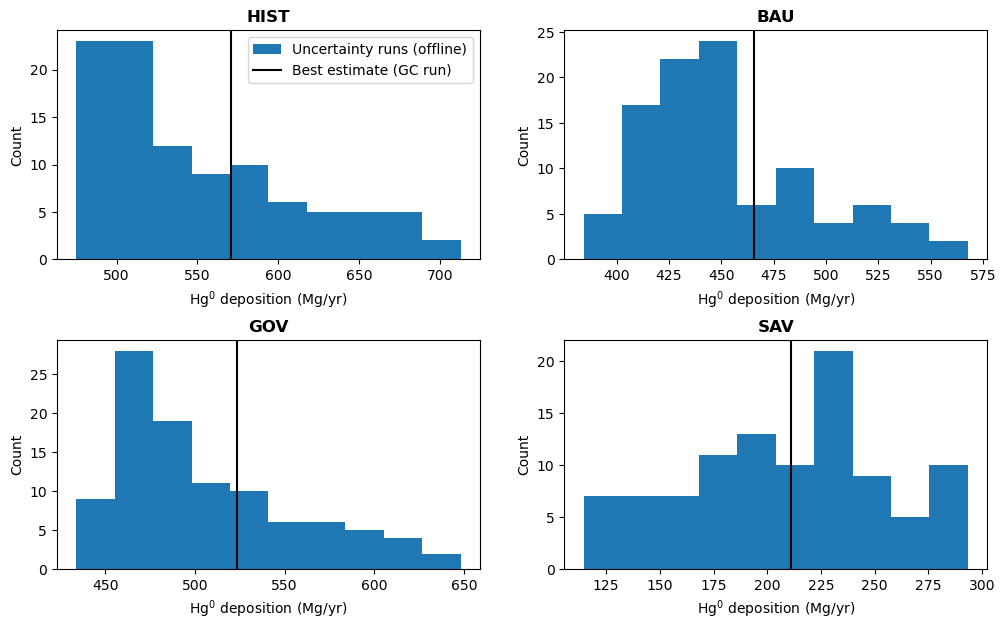

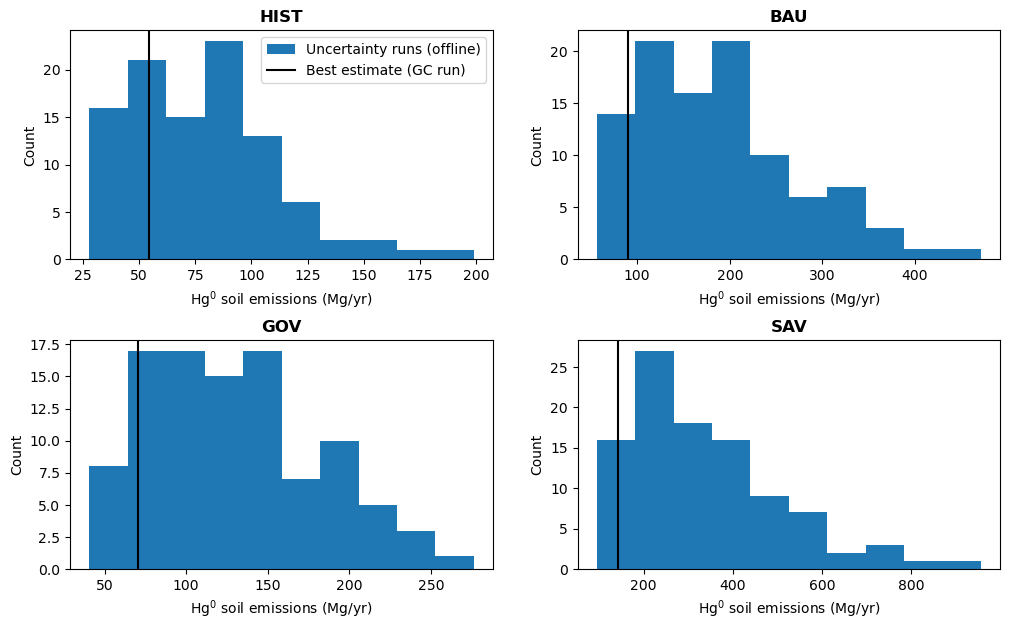

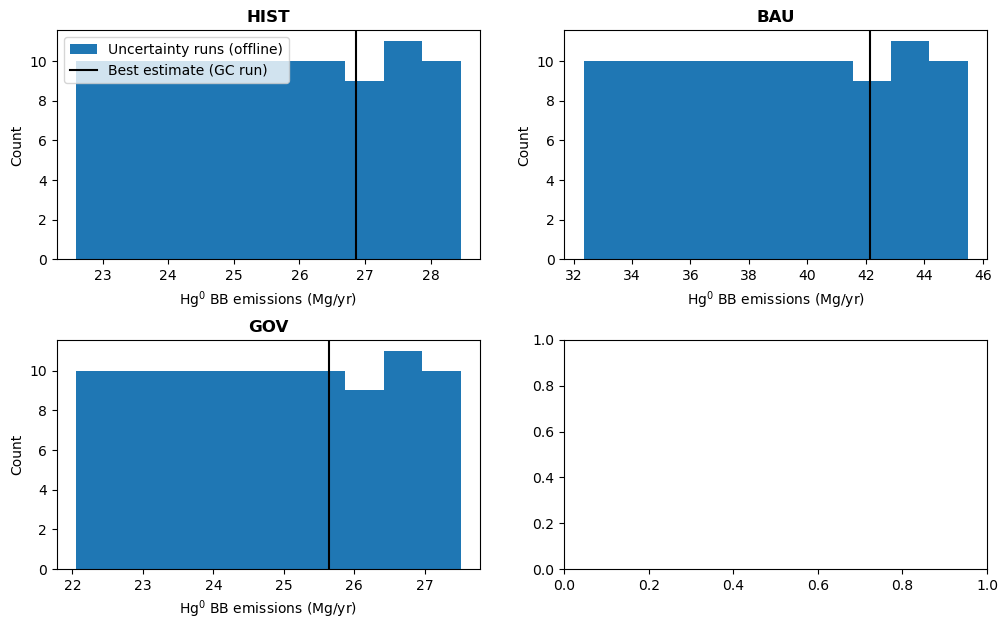

In [10]:
f, axes = plt.subplots(2, 2, figsize=[12,7],
                              gridspec_kw=dict(hspace=0.35, wspace=0.2))
axes = axes.flatten()
axes[0].hist(HIST_dep, label='Uncertainty runs (offline)')
axes[0].axvline(Am_dd_Hg0_tot[0], c='k', label = 'Best estimate (GC run)')
axes[0].set_xlabel('Hg$^0$ deposition (Mg/yr)')
axes[0].set_ylabel('Count')
axes[0].set_title('HIST', fontweight='bold')
axes[0].legend()

axes[1].hist(BAU_dep, label='Uncertainty runs (offline)')
axes[1].axvline(Am_dd_Hg0_tot[1], c='k', label = 'Best estimate (GC run)')
axes[1].set_xlabel('Hg$^0$ deposition (Mg/yr)')
axes[1].set_ylabel('Count')
axes[1].set_title('BAU', fontweight='bold')

axes[2].hist(GOV_dep, label='Uncertainty runs (offline)')
axes[2].axvline(Am_dd_Hg0_tot[2], c='k', label = 'Best estimate (GC run)')
axes[2].set_xlabel('Hg$^0$ deposition (Mg/yr)')
axes[2].set_ylabel('Count')
axes[2].set_title('GOV', fontweight='bold')

axes[3].hist(SAV_dep, label='Uncertainty runs (offline)')
axes[3].axvline(Am_dd_Hg0_tot[3], c='k', label = 'Best estimate (GC run)')
axes[3].set_xlabel('Hg$^0$ deposition (Mg/yr)')
axes[3].set_ylabel('Count')
axes[3].set_title('SAV', fontweight='bold')

f.savefig('/home/jovyan/colomb_ige-m2-internship-2025_MERCAMAZON-project/figures/unc_dep_histograms.pdf',bbox_inches = 'tight')


f, axes = plt.subplots(2, 2, figsize=[12,7],
                              gridspec_kw=dict(hspace=0.35, wspace=0.2))
axes = axes.flatten()
axes[0].hist(HIST_soil, label='Uncertainty runs (offline)')
axes[0].axvline(Am_soil_tot[0], c='k', label = 'Best estimate (GC run)')
axes[0].set_xlabel('Hg$^0$ soil emissions (Mg/yr)')
axes[0].set_ylabel('Count')
axes[0].set_title('HIST', fontweight='bold')
axes[0].legend()

axes[1].hist(BAU_soil, label='Uncertainty runs (offline)')
axes[1].axvline(Am_soil_tot[1], c='k', label = 'Best estimate (GC run)')
axes[1].set_xlabel('Hg$^0$ soil emissions (Mg/yr)')
axes[1].set_ylabel('Count')
axes[1].set_title('BAU', fontweight='bold')

axes[2].hist(GOV_soil, label='Uncertainty runs (offline)')
axes[2].axvline(Am_soil_tot[2], c='k', label = 'Best estimate (GC run)')
axes[2].set_xlabel('Hg$^0$ soil emissions (Mg/yr)')
axes[2].set_ylabel('Count')
axes[2].set_title('GOV', fontweight='bold')

axes[3].hist(SAV_soil, label='Uncertainty runs (offline)')
axes[3].axvline(Am_soil_tot[3], c='k', label = 'Best estimate (GC run)')
axes[3].set_xlabel('Hg$^0$ soil emissions (Mg/yr)')
axes[3].set_ylabel('Count')
axes[3].set_title('SAV', fontweight='bold')

f.savefig('/home/jovyan/colomb_ige-m2-internship-2025_MERCAMAZON-project/figures/unc_soil_histograms.pdf',bbox_inches = 'tight')

f, axes = plt.subplots(2, 2, figsize=[12,7],
                              gridspec_kw=dict(hspace=0.35, wspace=0.2))
axes = axes.flatten()
axes[0].hist(HIST_bb, label='Uncertainty runs (offline)')
axes[0].axvline(Am_bb_tot[0], c='k', label = 'Best estimate (GC run)')
axes[0].set_xlabel('Hg$^0$ BB emissions (Mg/yr)')
axes[0].set_ylabel('Count')
axes[0].set_title('HIST', fontweight='bold')
axes[0].legend()

axes[1].hist(BAU_bb, label='Uncertainty runs (offline)')
axes[1].axvline(Am_bb_tot[1], c='k', label = 'Best estimate (GC run)')
axes[1].set_xlabel('Hg$^0$ BB emissions (Mg/yr)')
axes[1].set_ylabel('Count')
axes[1].set_title('BAU', fontweight='bold')

axes[2].hist(GOV_bb, label='Uncertainty runs (offline)')
axes[2].axvline(Am_bb_tot[2], c='k', label = 'Best estimate (GC run)')
axes[2].set_xlabel('Hg$^0$ BB emissions (Mg/yr)')
axes[2].set_ylabel('Count')
axes[2].set_title('GOV', fontweight='bold')

f.savefig('/home/jovyan/colomb_ige-m2-internship-2025_MERCAMAZON-project/figures/unc_bb_histograms.pdf',bbox_inches = 'tight')
#%% Calculate P5-P95 differences, to be plotted in bar graph
# calculate full distributions of Amazon mass balance in the scenarios
Balance_unc_HIST = Balance[0] - \
    Am_soil_tot[0] - Am_bb_tot[0] + Am_dd_Hg0_tot[0] + \
    HIST_soil + HIST_bb - HIST_dep

Balance_unc_BAU = Balance[1] - \
    Am_soil_tot[1] - Am_bb_tot[1] + Am_dd_Hg0_tot[1] + \
    BAU_soil + BAU_bb - BAU_dep
    
Balance_unc_GOV = Balance[2] - \
    Am_soil_tot[2] - Am_bb_tot[2] + Am_dd_Hg0_tot[2] + \
    GOV_soil + GOV_bb - GOV_dep

Balance_unc_SAV = Balance[3] - \
    Am_soil_tot[3] + Am_dd_Hg0_tot[3] + \
    SAV_soil - SAV_dep

# Balance_unc_HIST = Balance[0] + \
#     Am_dd_Hg0_tot[0] - \
#      HIST_dep

# Balance_unc_BAU = Balance[1] + \
#     Am_dd_Hg0_tot[1] - \
#     BAU_dep
    
# Balance_unc_GOV = Balance[2] + \
#     Am_dd_Hg0_tot[2] - \
#     GOV_dep

# Balance_unc_SAV = Balance[3] + \
#      Am_dd_Hg0_tot[3] \
#     - SAV_dep

# Balance_unc_HIST = Balance[0] - \
#     Am_soil_tot[0] + \
#       HIST_soil

# Balance_unc_BAU = Balance[1] - \
#     Am_soil_tot[1] + \
#     BAU_soil
    
# Balance_unc_GOV = Balance[2] - \
#     Am_soil_tot[2] + \
#     GOV_soil

# Balance_unc_SAV = Balance[3] - \
#       Am_soil_tot[3] \
#     + SAV_soil

P25_vals = [np.percentile(Balance_unc_HIST,2.5), np.percentile(Balance_unc_BAU,2.5),
           np.percentile(Balance_unc_GOV,2.5), np.percentile(Balance_unc_SAV,2.5)]
P975_vals = [np.percentile(Balance_unc_HIST,97.5), np.percentile(Balance_unc_BAU,97.5),
           np.percentile(Balance_unc_GOV,97.5), np.percentile(Balance_unc_SAV,97.5)]
yerr = np.zeros((2,4)) # for error bars
yerr[0,:] = Balance - P25_vals # lower bars
yerr[1,:] = -Balance + P975_vals # upper bars


### Plot stacked bar graph

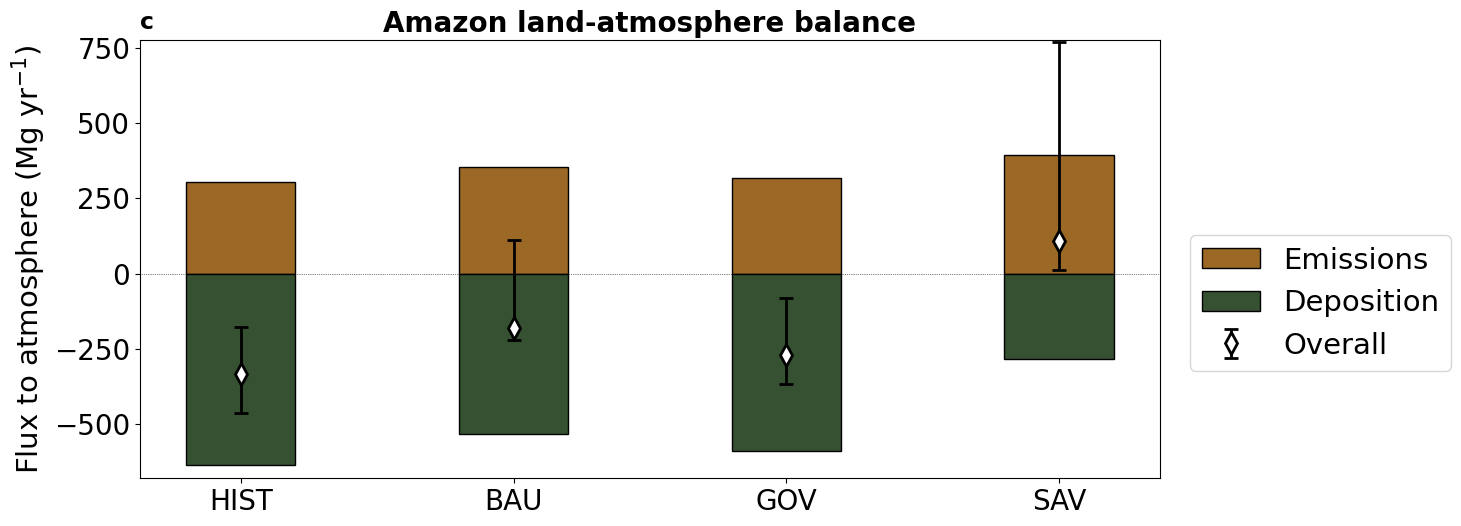

In [12]:
fig, ax = plt.subplots(figsize=[17,6])
fig.subplots_adjust(bottom=0.15, left=0.2, right=0.8) # <-- Change the 0.02 to work for your plot.

ax.bar(sim_name, Emiss_tot, 0.4, label='Emissions', color='#9B6826', edgecolor='k') # stacked
#ax.bar(sim_name, Erosion, 0.4, label='Erosion', color='#D6C7A7', edgecolor='k')
ax.bar(sim_name, -1*Dep_tot, 0.4, color='#365131', label='Deposition', edgecolor='k')
plt.axhline(y=0., color='k', linestyle=':', linewidth=0.5)
plt.errorbar(sim_name,Balance, yerr=yerr, fmt='d', 
             capthick=3, capsize=5, elinewidth=2, ecolor='k',
             mec='k',mfc='w',mew=2, markersize=11, label='Overall')#'_nolegend_')
#plt.plot(sim_name,Balance,'d',mec='k',mfc='w',mew=1, markersize=8, label='Overall')

ax.set_ylabel('Flux to atmosphere (Mg yr$^{-1}$)', fontsize=21)
ax.set_title('Amazon land-atmosphere balance', fontsize=20, fontweight='bold')
ax.legend(fontsize=21, loc='center right',bbox_to_anchor=(1.3,0.4))
#          ncol=4, columnspacing = 0.2)
ax.set_ylim([-680,775])
ax.tick_params(labelsize=20) 
ax.text(0.0, 1.04, 'c', fontweight='bold',fontsize=17,
             horizontalalignment='left', verticalalignment='center',
             transform=ax.transAxes)

plt.show()
fig.savefig('/home/jovyan/colomb_ige-m2-internship-2025_MERCAMAZON-project/figures/Mass_balance_Am_v3.pdf',bbox_inches = 'tight')